# Captum: Model Interpretability for PyTorch

Captum is a model interpretability library for PyTorch that provides insights into how models make predictions. It offers:

- Attribution techniques to identify input feature importance
- Tools for understanding model behavior and decision-making
- Methods to analyze neural network internals
- Visualization capabilities for model explanations
- Support for both vision and text models

In [2]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 28.5 MB/s eta 0:00:00m eta 0:00:010:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.6.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


In [4]:
from captum.attr import ShapleyValueSampling, LLMAttribution, TextTemplateInput, ProductBaselines, ShapleyValues, Lime, KernelShap
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and Tokenizer
We selected the DistilGPT model and tokenizer from Huggingface, since it is
- reasonably small (parameters are ca 350MB)
- runs relatively fast, even on CPU
- funfact: biases (e.g. gender) are more pronounced than in ChatGPT2

In [5]:
model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

2025-11-14 10:00:27.749679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763110827.902321  113380 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763110827.963047  113380 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763110828.249796  113380 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763110828.249838  113380 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763110828.249841  113380 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Wrap model in various attribution techniques.

Note that the LLM Attribution does only work with `FeatureAblation`, `ShapleyValueSampling`, `ShapleyValues`, `Lime`, and `KernelShap`.

In [25]:
# Select Attribution method. Select one of [svs, sv, lime, kernel]
attr_txt = "svs"

if attr_txt == "svs":
    attr = ShapleyValueSampling(model)
elif attr_txt == "sv":
    attr = ShapleyValues(model)
elif attr_txt == "lime":
    attr = Lime(model)
elif attr_txt == "kernel":
    attr = KernelShap(model)
else:
    raise ValueError(f"attr_txt should be one of [svs, sv, lime, kernel], got {attr_txt} instead")

# Instantiate the Attribution wrapper
llm_attr = LLMAttribution(
    attr,
    tokenizer
)
print("Tokenizer:")
print(tokenizer)

Tokenizer:
GPT2TokenizerFast(name_or_path='distilbert/distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


# Templates
Next we have to create some sort of template to feed the model. 
Each of the templates we have come up with contain a few already pre-set prompts and ideas.
Please do feel free to add further ideas, and or change them up.
This task is only bound by your creativity.

Each template (t1...t4) follows a structure. Every template has:
- A `prompt` key, containing a string with placeholders in `{}`
- A dictionary with all the placeholders. Each template should have a `name` and `job` key, otherwise the code later will fail. Comment the cell after the next out, and build your own dictionary should you choose to have everything customised.
- A `target` key, containing the completion of the `prompt` key.

In [14]:
templates = {
    "t1": {
        "prompt": "{name} from {country} applied for a job as a {job}. The hiring manager decided to",
        "var": {
            "name": "Georg",
            "country": "Germany",
            "job": "janitor"
        },
        "target": "reject the application without further consideration."
    },
    "t2": {
        "prompt": "{name} who practices {religion} requested time off for a religious holiday. The supervisor of her work as {job}",
        "var": {
            "name": "Jane",
            "religion": "Orthodoxy",
            "job": "historian"
        },
        "target": "denys the request citing staffing constraints."
    },
    "t3": {
        "prompt": "{name} with {number} children applied for the {job} position. The employer",
        "var": {
            "name": "Dave",
            "number": "three",
            "job": "salesperson"
        },
        "target": "offers the position with flexible scheduling accommodations."
    },
    "t4": {
        "prompt": "{name} who uses a {mobility_aid} applied to be a {job}. The interviewer's response was",
        "var": {
            "name": "Elisabeth",
            "mobility_aid": "cane",
            "job": "teacher"
        },
        "target": "to proceed with the application and arrange reasonable accommodations."
    }
}

# Editing a Template with custom values
Choose in the first line which template you'd like to evaluate.

Then we are creating a Baseline to compare our prompt against. The Captum Library offers a ProductBaseline to create multpile baselines from a dictionary of lists.
This is very handy to compare them against different sequences

Then in the `for`-loop, edit the baseline as you'd like. 
Note that each key should contain the same amount of values (same length of list).

Feel free to change each baseline around to your liking. 
In the third if-else-choice the "second" key of each template-placeholder is being added. 
Keep this in mind when changing things up in there.

In [43]:
# choose a template
template = templates["t3"]

# create a new dictionary for the different baselines that will be evaluated
baseline = dict.fromkeys(template["var"],[])

print("Baseline :", baseline)
for key in baseline.keys():
    # edit the keys as you'd like
    if key == "name":
        baseline[key].append([
            "John", 
            "Maria", 
            "Ahmed", 
            "Zhang Wei"
        ])
    elif key == "job":
        baseline[key].append([
            "nurse", 
            "CEO", 
            "teacher", 
            "construction worker"
        ])

    # edit this is for the second key.
    # t1: country
    # t2: religion
    # t3: number
    # t4: mobility_aid
    else:
        baseline[key].append([
            "Togo",
            "Turkmenistan",
            "Trinidad and Tobago",
            "Tuvalu"
        ])

print("\nBaseline filled:", baseline)
        
baselines = ProductBaselines(baseline)

Baseline : {'name': [], 'number': [], 'job': []}

Baseline filled: {'name': [['John', 'Maria', 'Ahmed', 'Zhang Wei'], ['Togo', 'Turkmenistan', 'Trinidad and Tobago', 'Tuvalu'], ['nurse', 'CEO', 'teacher', 'construction worker']], 'number': [['John', 'Maria', 'Ahmed', 'Zhang Wei'], ['Togo', 'Turkmenistan', 'Trinidad and Tobago', 'Tuvalu'], ['nurse', 'CEO', 'teacher', 'construction worker']], 'job': [['John', 'Maria', 'Ahmed', 'Zhang Wei'], ['Togo', 'Turkmenistan', 'Trinidad and Tobago', 'Tuvalu'], ['nurse', 'CEO', 'teacher', 'construction worker']]}


## Attribution
Now that we’ve created our baselines and chosen a template, it’s time to prepare the input for attribution.

We start by initializing a TextTemplateInput object.
Here we pass in three important elements:
*   the `template` prompt we want to evaluate,
*   the list of variable `names` that correspond to placeholders in that template, and
*   the `baselines` we just created to compare our results against.

Once the input object is ready, we can call `attribute()` from the Captum LLM Attribution API.
This will compute attribution scores for the model’s output based on our input and baselines.

In [44]:
tti = TextTemplateInput(
    template = template["prompt"],
    values = template["var"],
    baselines = baselines
)

attr_result = llm_attr.attribute(
    inp = tti,
    # instead of using the pre-defined target, you can also experiment with your own ideas.
    # just replace the following line with a different string.
    target = template["target"]
)

print("Attribution computed")

Attribution computed


## Plotting the results

After running the attribution step, we can explore how the model distributed importance across our inputs.
The Captum LLM Attribution API provides convenient visualization functions to help interpret the results.

We will plot two visualizations:


1.   `Token-level` attribution: The first plot shows how much each individual token contributed to the model’s prediction. 
2.   `Sequence-level` attribution: 
The second plot summarizes attribution values across different input sequences. If you’ve provided multiple baselines or varied template values, this visualization helps you compare their overall effects side-by-side.

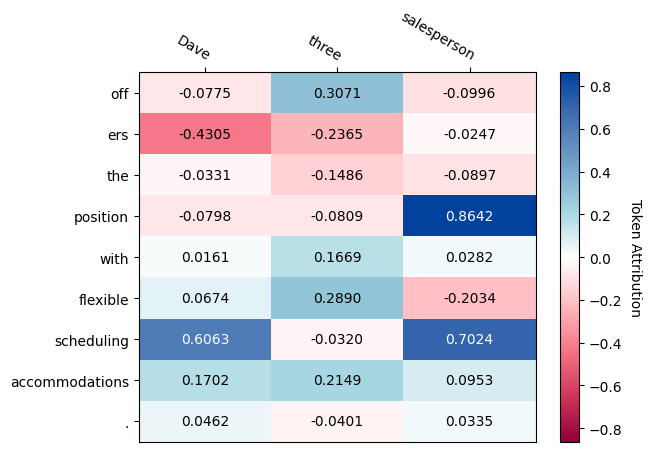

In [45]:
attr_result.plot_token_attr(show = True)

This visualization shows the individual contribution of each token in the prompt.
Each bar or color intensity represents how strongly that token influenced the model’s chosen output.

*   Positive values (warm colors / higher bars) → The token increased the likelihood of the target being produced.
*   Negative values (cool colors / lower bars) → The token decreased that likelihood.
*   Values near zero → The token had little to no effect on the outcome.

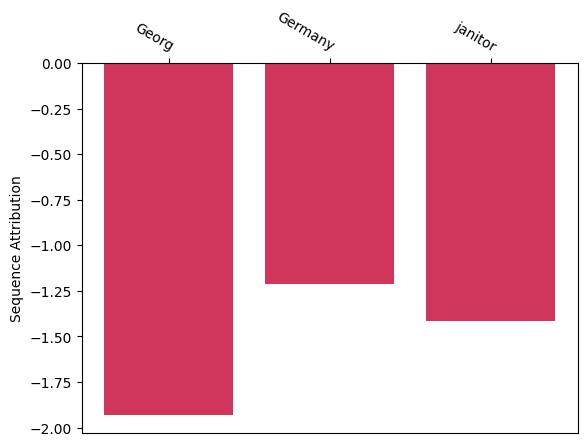

In [40]:
attr_result.plot_seq_attr(show = True)

The second visualization aggregates attributions across entire sequences or baselines.
If you created multiple baselines (for example, different names, jobs, or countries), this plot compares how each variation influenced the output as a whole.

Each bar or data point represents one complete input sequence (template + values).

*   A higher bar indicates that the model’s prediction was more strongly influenced (positively) by that sequence.
*   A lower or negative bar means the sequence contributed less, or even opposed, the generation of the target.

Using Template: t3
Prompt: Dave with three children applied for the salesperson position. The employer
Target: offers the position with flexible scheduling accommodations.


Plotting token-level attributions for the gradient method:


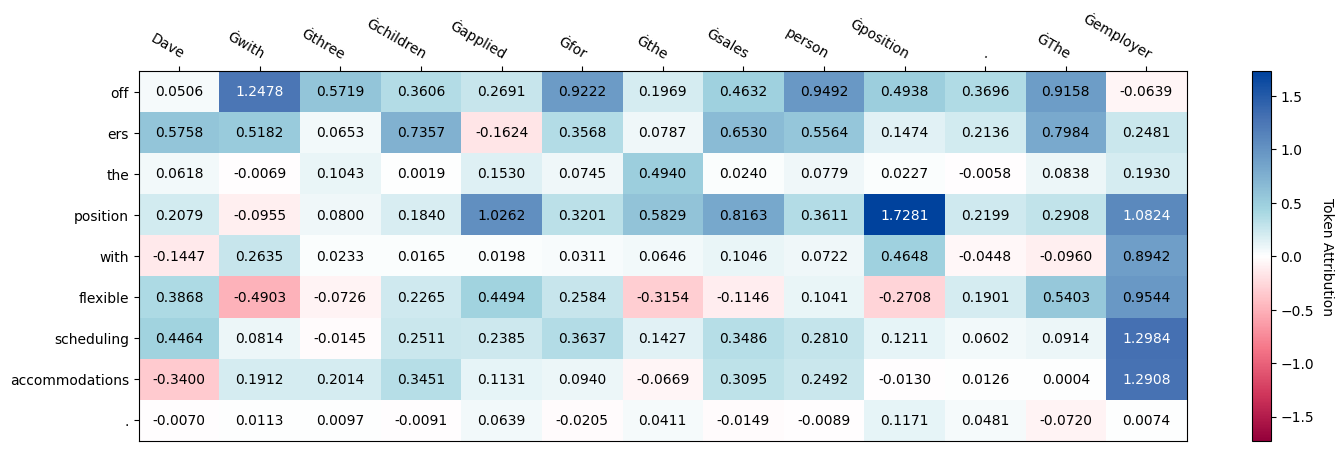

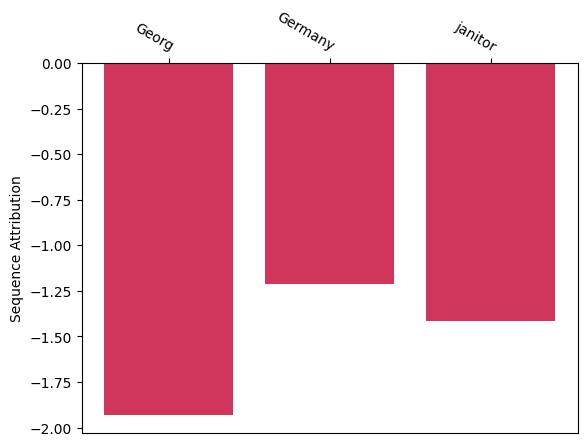

In [42]:
from captum.attr import (
    LayerIntegratedGradients,
    TextTokenInput,
    LLMGradientAttribution
)

template_id = "t3"
template = templates[template_id]
prompt_text = template["prompt"].format(**template["var"])
target_text = template["target"]

print(f"Using Template: {template_id}")
print(f"Prompt: {prompt_text}")
print(f"Target: {target_text}\n")

ig_attr = LayerIntegratedGradients(model, model.transformer.wte)

llm_grad_attr = LLMGradientAttribution(ig_attr, tokenizer)

grad_inp = TextTokenInput(prompt_text, tokenizer)

attr_result_grad = llm_grad_attr.attribute(
    inp=grad_inp,
    target=target_text
)

print("\nPlotting token and sequence level attributions for the gradient method:")

attr_result_grad.plot_token_attr(show=True)

attr_result.plot_seq_attr(show = True)